In [1]:
import pandas
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# train test split
from sklearn.model_selection import train_test_split

/Users/danielkim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_directory = 'data/'
data_file = 'emotions_labeled.csv'

df = pandas.read_csv(data_directory + data_file)

In [3]:
def clean_data(df):
    df = df[["Delta Averaged", "Theta Averaged", "Alpha Averaged", "Beta Averaged", "Gamma Averaged", "Relaxed", "Time Averaged", "Funny/Happy"]]
    # rename columns
    df = df.dropna()
    # drop number index


    df = df.rename(columns={"Delta Averaged": "delta", "Theta Averaged": "theta", "Alpha Averaged": "alpha", "Beta Averaged": "beta", "Gamma Averaged": "gamma", "Relaxed": "relaxed", "Time Averaged": "time", "Funny/Happy": "happy"})
    
    
    return df

In [4]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {"input": self.data[idx], "label": self.labels[idx]}
        return sample

In [5]:
df = clean_data(df)
df.head()   x

,delta,theta,alpha,beta,gamma,relaxed,time,happy
0,0.049613,0.357985,0.190308,0.264495,0.137599,1,0.197205,0
1,0.050901,0.345767,0.190629,0.269995,0.142708,1,0.331969,0
2,0.050980,0.330472,0.198418,0.276494,0.143636,1,0.465711,0
3,0.049446,0.333421,0.207266,0.273468,0.136399,1,0.596464,0
4,0.047684,0.342692,0.215552,0.267410,0.126662,1,0.730908,0


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'delta'}>, <AxesSubplot:>]],
      dtype=object)

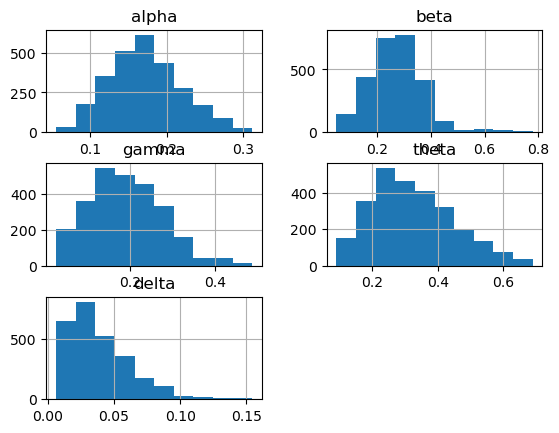

In [6]:
# plot distribution of delta frequency when relaxed is not true
# df[['alpha', 'beta', 'gamma', 'theta', 'delta']].hist()

# show each emotion's distribution of delta frequency
df[df['relaxed'] == 1][['alpha', 'beta', 'gamma', 'theta', 'delta']].hist()


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'delta'}>, <AxesSubplot:>]],
      dtype=object)

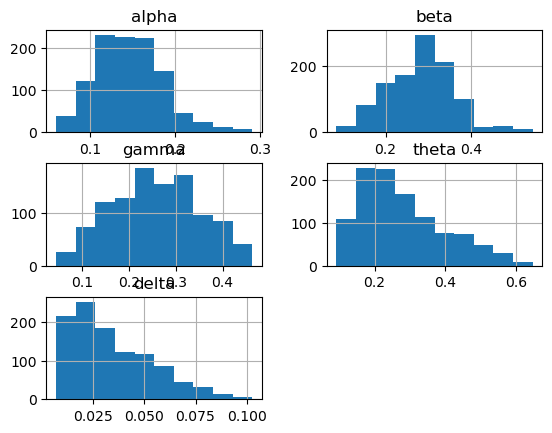

In [7]:
df[df['relaxed'] == 0][['alpha', 'beta', 'gamma', 'theta', 'delta']].hist()


In [8]:
# show average value of each frequency when relaxed is not true
df[df.relaxed == False][['alpha', 'beta', 'gamma', 'theta', 'delta']].mean()

alpha    0.146283
beta     0.282120
gamma    0.257669
theta    0.279375
delta    0.034552
dtype: float64

In [9]:
df[df.relaxed == True][['alpha', 'beta', 'gamma', 'theta', 'delta']].mean()

alpha    0.172499
beta     0.271547
gamma    0.191434
theta    0.325404
delta    0.039116
dtype: float64

In [10]:
# create train and test set from df

# split into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)
# make index start from 0
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [11]:
train_data = train[["theta", "beta", "gamma"]].values  # Replace with your input features
train_labels = train["relaxed"].values  # Replace with your labels

test_data = test[["theta", "beta", "gamma"]].values  # Replace with your input features
test_labels = test["relaxed"].values  # Replace with your labels

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

In [12]:
from torch.utils.data import DataLoader

batch_size = 16  # Adjust this to your preference
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



In [13]:
# distribution of relaxed in test
test.relaxed.value_counts()

1    557
0    196
Name: relaxed, dtype: int64

In [16]:

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # Define your layers in the __init__ method
        self.fc1 = nn.Linear(3, 16)  # Example: Define your fully connected layer here
        self.relu = nn.ReLU()  # Example: Activation function
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        # Define your forward pass in the forward method
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = Network()



In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

input_columns = ["alpha", "beta", "gamma"]
target_column = "relaxed"

# Define batch size


# Create a DataLoader using trainloader

# Train network
epochs = 40
for e in range(epochs):
    running_loss = 0
    for batch in trainloader:

        inputs = batch["input"].to(torch.float32)
        labels = batch["label"].view(-1,1).float()
        
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    else:
        print("Epoch: {}/{}.. ".format(e + 1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss / len(trainloader)))

Epoch: 1/40..  Training Loss: 0.741.. 
Epoch: 2/40..  Training Loss: 0.649.. 
Epoch: 3/40..  Training Loss: 0.613.. 
Epoch: 4/40..  Training Loss: 0.604.. 
Epoch: 5/40..  Training Loss: 0.600.. 
Epoch: 6/40..  Training Loss: 0.602.. 
Epoch: 7/40..  Training Loss: 0.596.. 
Epoch: 8/40..  Training Loss: 0.594.. 
Epoch: 9/40..  Training Loss: 0.594.. 
Epoch: 10/40..  Training Loss: 0.592.. 
Epoch: 11/40..  Training Loss: 0.590.. 
Epoch: 12/40..  Training Loss: 0.587.. 
Epoch: 13/40..  Training Loss: 0.587.. 
Epoch: 14/40..  Training Loss: 0.585.. 
Epoch: 15/40..  Training Loss: 0.585.. 
Epoch: 16/40..  Training Loss: 0.579.. 
Epoch: 17/40..  Training Loss: 0.580.. 
Epoch: 18/40..  Training Loss: 0.576.. 
Epoch: 19/40..  Training Loss: 0.577.. 
Epoch: 20/40..  Training Loss: 0.573.. 
Epoch: 21/40..  Training Loss: 0.572.. 
Epoch: 22/40..  Training Loss: 0.571.. 
Epoch: 23/40..  Training Loss: 0.572.. 
Epoch: 24/40..  Training Loss: 0.568.. 
Epoch: 25/40..  Training Loss: 0.570.. 
Epoch: 26

In [18]:
# test network
correct = 0
total = 0

predictions = []

with torch.no_grad():
    for i, row in test.iterrows():
        labels = torch.tensor(
            [row[target_column]], dtype=torch.float32
        )  # Convert label to Tensor with shape [1]
        inputs = torch.tensor(
            row[input_columns].values, dtype=torch.float32
        )  # Convert input features to Tensor

        outputs = model(inputs)
        predicted = torch.round(outputs.data)
        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Accuracy: %d %%" % (100 * correct / total))


Accuracy: 75 %


/Users/danielkim/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielkim/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


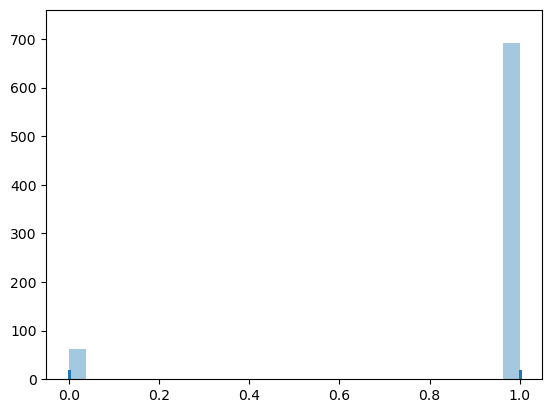

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# show distribution of guesses from predictions
predictions = np.array(predictions)
sns.distplot(predictions, kde=False, rug=True);


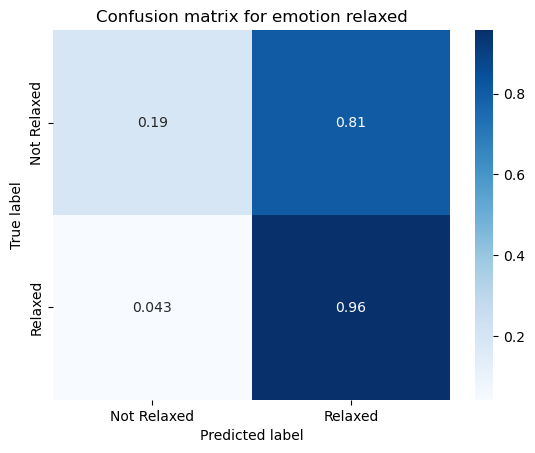

In [20]:
# show confusion matrix with labels and percentages


y_true = test[target_column]
y_pred = predictions

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Not Relaxed', 'Relaxed'], yticklabels=['Not Relaxed', 'Relaxed'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for emotion relaxed')
plt.show()
# label the confusion matrix




In [18]:


# predict using this data